# Bag Of Visual Words - BOVW

# Import libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle

# BOVW Driver code

In [2]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm

from glob import glob
from collections import OrderedDict

class BOVW:
    def __init__(self, k_cluster, normalization, train_path = "../dataset/Simpler/dataset/SUN_data/train/", test_path = "./Simpler/dataset/SUN_data/test/"):
        self.map_index_category = os.listdir(train_path)
        self.map_category_index = {self.map_index_category[i]:i for i in range(len(self.map_index_category))}
        if ( normalization == True):
            self.normalization = True
        if (normalization == False):
            self.normalization = False
        train_image = OrderedDict()
        test_image = OrderedDict()
        for path in self.map_index_category:
            full_path_train = train_path + path + "/*.jpg"
            train_image[path] = [cv2.cvtColor(cv2.imread(img_file_name), cv2.COLOR_BGR2GRAY) for img_file_name in glob(full_path_train)]
            full_path_test = test_path + path + "/*.jpg"
            test_image[path] = [cv2.cvtColor(cv2.imread(img_file_name), cv2.COLOR_BGR2GRAY) for img_file_name in glob(full_path_test)]
        
        sift = cv2.xfeatures2d.SIFT_create()
        def feature_extraction(images):
            dim = (0,128)
            descriptor_list = np.empty(shape = dim)
            sift_vectors = OrderedDict()
            it = images.items()
            for category, images_list in it:
                keypoints = []
                descriptors = []
                sift_vectors[category] = []
                for img in images_list:
                    kp, des = sift.detectAndCompute(img, None)
                    keypoints.append(kp)
                    descriptors.append(des)
                    descriptor_list = np.append(descriptor_list, des, axis = 0)
                    sift_vectors[category].append(des)
            return descriptor_list, sift_vectors
        
        
        (train_descriptor_list, train_sift_vectors) = feature_extraction(train_image)
        (test_descriptor_list, test_sift_vectors) = feature_extraction(test_image)
        
        np.save("train_descriptor_list", train_descriptor_list)
        np.save("test_descriptor_list", test_descriptor_list)
        
        f = open("train_sift_vectors.pkl", 'wb')
        try:
            pickle.dump(train_sift_vectors, f)
        finally:
            f.close()
        f = open("test_sift_vectors.pkl", 'wb')
        try:
            pickle.dump(test_sift_vectors, f)
        finally:
            f.close()
        
        print("Quantizing Images")
        fit_type = train_descriptor_list.astype(np.float32)
        fit_f32 = fit_type.astype(np.float32)
        kmeans = KMeans(n_clusters = k_cluster).fit(fit_f32)
        print("Images Quantized") 
        self.bovw_train = self.bovw_histogram_output(train_sift_vectors, kmeans)
        self.bovw_test =  self.bovw_histogram_output(test_sift_vectors, kmeans)
        
    def save(self, filename):
        f = open(filename, 'wb')
        try:
            pickle.dump(self, f)
        finally:
            f.close()
    
    @staticmethod
    def load(filename):
        f = open(filename, 'rb')
        try:
            return pickle.load(f)
        finally:
            f.close()
    
    def bovw_histogram_output(self, data_sift_vectors, kmeans):
        histogram_feature = []
        dsv_i = data_sift_vectors.items()
        for category, images_sift_vectors in dsv_i:
            for img_des_vectors in images_sift_vectors:
                shape_clus = kmeans.n_clusters+1
                histogram = np.zeros(shape = shape_clus)
                pred = kmeans.predict(img_des_vectors)
                pred_int = pred.astype(int)
                for i in pred_int:
                    histogram[i] = histogram[i] + 1
                if self.normalization == True:
                    histogram_total = histogram.sum()
                    histogram = histogram/histogram_total
                map_cat_i = self.map_category_index[category]
                histogram[-1] = map_cat_i
                histogram_feature.append(histogram)
        return np.array(histogram_feature)
    
    def train(self, model_file):
        slice1 = self.bovw_train[:, :-1]
        slice2 = self.bovw_train[:, -1]
        clf = OneVsRestClassifier(svm.SVC()).fit(slice1, slice2)
        f = open(model_file, "wb")
        try:
            pickle.dump(clf, f)
        finally:
            f.close()
    
    def test(self, model_file):
        f = open(model_file, "rb")
        try:
            clf = pickle.load(f)
        finally:
            f.close()
        a = clf.predict(self.bovw_test[:, :-1])
        b = self.bovw_test[:, -1]
        a_int = a.astype(int)
        b_int = b.astype(int)
        return a_int, b_int

def calc_metrics(predicted_output, actual_output, bovw_obj, test_path = "../dataset/Simpler/dataset/SUN_data/test/"):
    confusion_matrix = metrics.confusion_matrix(actual_output, predicted_output)
    print("Confusion Matrix:\n",confusion_matrix)
    acc_score = np.trace(confusion_matrix) / len(predicted_output)
    acc_score = acc_score * 100
    print("Accuracy percentage:", acc_score, "%")
    test_images = []
    for path in bovw_obj.map_index_category:
        full_path = test_path + path + "/*.jpg"
        test_images.extend([cv2.cvtColor(cv2.imread(img_file_name), cv2.COLOR_BGR2RGB) for img_file_name in glob(full_path)])
    indices = np.where(predicted_output != actual_output)[0]
    for i in np.random.choice(indices, size = 3).astype(int):
        found = 0
        predict = bovw_obj.map_index_category[predicted_output[i]]
        print("Predicted Label: " + predict)
        actual = bovw_obj.map_index_category[actual_output[i]]
        print("Actual label: " + actual)
        plt.imshow(test_images[i])
        plt.show()
        if ( bovw_obj.map_index_category[predicted_output[i]] == bovw_obj.map_index_category[actual_output[i]] ):
            found = 1
            break

## Execution code - Pre_Processing - Quantization

In [3]:
train_path = "../dataset/Simpler/dataset/SUN_data/train/"
test_path = "../dataset/Simpler/dataset/SUN_data/test/"

print ("Processing - 70 - Without Normalisation")
b = BOVW(70, False, train_path = train_path, test_path = test_path)
b.save("../SVM/70_wo_norm.pkl")
print("\n")

print ("Processing - 50 - Without Normalisation")
b = BOVW(50, False, train_path = train_path, test_path = test_path)
b.save("../SVM/50_wo_norm.pkl")
print("\n")

print ("Processing - 70 - With Normalisation")
b = BOVW(70, True, train_path = train_path, test_path = test_path)
b.save("../SVM/70_w_norm.pkl")
print("\n")

print ("Processing - 50 - With Normalisation")
b = BOVW(50, True, train_path = train_path, test_path = test_path)
b.save("../SVM/50_w_norm.pkl")
print("\n")

Processing - 70 - Without Normalisation
Quantizing Images
Images Quantized


Processing - 50 - Without Normalisation
Quantizing Images
Images Quantized


Processing - 70 - With Normalisation
Quantizing Images
Images Quantized


Processing - 50 - With Normalisation
Quantizing Images
Images Quantized




## Training - 70 and 50 visual words - With and Without normalisation

In [4]:
load_path = "70_wo_norm.pkl"
b = BOVW.load(load_path)
SVM_path = "../SVM/"+load_path
b.train(SVM_path)
print("Images trained - 70 - Without Normalisation")

load_path = "50_wo_norm.pkl"
b = BOVW.load(load_path)
SVM_path = "../SVM/"+load_path
b.train(SVM_path)
print("Images trained - 50 - Without Normalisation")

load_path = "70_w_norm.pkl"
b = BOVW.load(load_path)
SVM_path = "../SVM/"+load_path
b.train(SVM_path)
print("Images trained - 70 - With Normalisation")

load_path = "50_w_norm.pkl"
b = BOVW.load(load_path)
SVM_path = "../SVM/"+load_path
b.train(SVM_path)
print("Images trained - 50 - With Normalisation")

Images trained - 70 - Without Normalisation
Images trained - 50 - Without Normalisation
Images trained - 70 - With Normalisation
Images trained - 50 - With Normalisation


## Test - 70 and 50 visual words - With and Without normalisation

***** Images Tested - 70 - Without Normalisation *****
Confusion Matrix:
 [[3 1 5 0 0 0 0 1]
 [1 2 2 1 1 1 2 0]
 [4 0 6 0 0 0 0 0]
 [0 0 0 5 0 1 3 1]
 [0 2 4 0 2 2 0 0]
 [1 0 2 0 0 7 0 0]
 [0 0 2 0 0 0 7 1]
 [1 0 2 0 0 1 0 6]]
Accuracy percentage: 47.5 %
Predicted Label: park
Actual label: aquarium


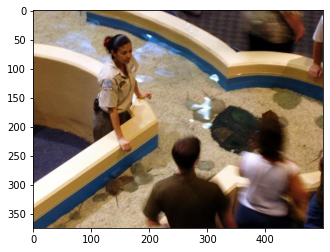

Predicted Label: waterfall
Actual label: park


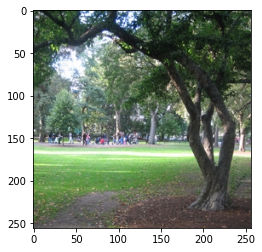

Predicted Label: waterfall
Actual label: highway


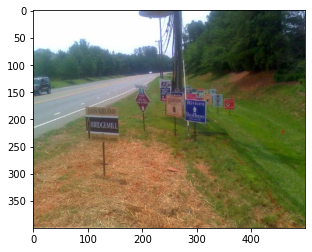



***** Images Tested - 50 - Without Normalisation *****
Confusion Matrix:
 [[3 1 5 0 0 0 0 1]
 [0 2 2 3 2 1 0 0]
 [3 0 6 0 1 0 0 0]
 [0 1 0 3 1 1 4 0]
 [0 0 4 1 2 2 0 1]
 [1 0 2 0 0 6 0 1]
 [0 0 4 2 0 0 4 0]
 [0 0 2 0 0 1 0 7]]
Accuracy percentage: 41.25 %
Predicted Label: park
Actual label: kitchen


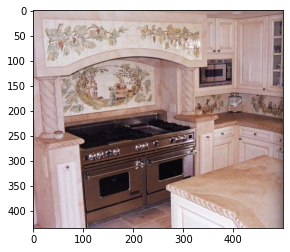

Predicted Label: aquarium
Actual label: windmill


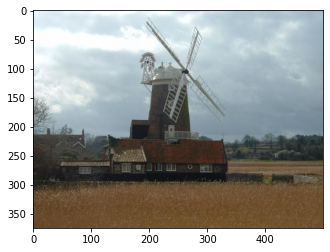

Predicted Label: kitchen
Actual label: laundromat


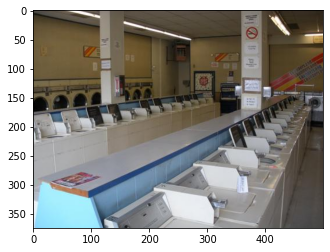



***** Images Tested - 70 - With Normalisation *****
Confusion Matrix:
 [[4 0 5 0 0 1 0 0]
 [2 3 1 2 0 1 0 1]
 [1 1 8 0 0 0 0 0]
 [0 2 0 5 1 0 2 0]
 [0 0 3 1 4 1 0 1]
 [3 0 0 0 1 5 0 1]
 [0 1 0 3 0 0 6 0]
 [0 0 0 0 0 2 1 7]]
Accuracy percentage: 52.5 %
Predicted Label: waterfall
Actual label: desert


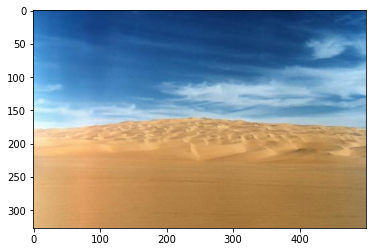

Predicted Label: highway
Actual label: laundromat


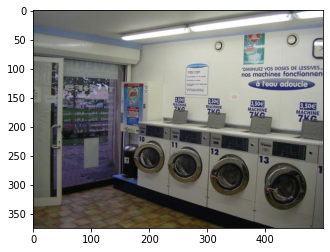

Predicted Label: waterfall
Actual label: desert


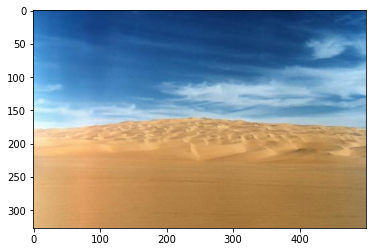



***** Images Tested - 50 - With Normalisation *****
Confusion Matrix:
 [[4 0 5 0 0 0 0 1]
 [1 3 1 3 0 1 0 1]
 [1 0 8 0 1 0 0 0]
 [0 0 0 6 2 0 2 0]
 [0 0 3 0 3 3 1 0]
 [3 1 0 0 0 5 0 1]
 [0 0 0 4 0 0 6 0]
 [0 0 0 0 0 3 2 5]]
Accuracy percentage: 50.0 %
Predicted Label: desert
Actual label: aquarium


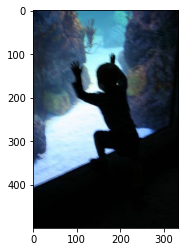

Predicted Label: desert
Actual label: highway


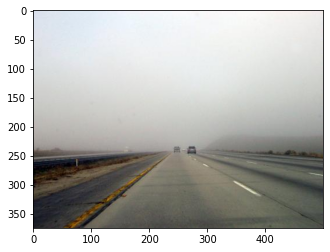

Predicted Label: waterfall
Actual label: park


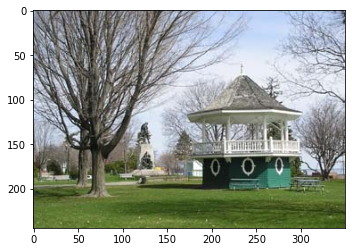

In [5]:
print("***** Images Tested - 70 - Without Normalisation *****")
load_path = "70_wo_norm.pkl"
b = BOVW.load(load_path)
SVM_path = "../SVM/"+load_path
calc_metrics(*b.test(SVM_path), b)
print("\n")

print("***** Images Tested - 50 - Without Normalisation *****")
load_path = "50_wo_norm.pkl"
b = BOVW.load(load_path)
SVM_path = "../SVM/"+load_path
calc_metrics(*b.test(SVM_path), b)
print("\n")

print("***** Images Tested - 70 - With Normalisation *****")
load_path = "70_w_norm.pkl"
b = BOVW.load(load_path)
SVM_path = "../SVM/"+load_path
calc_metrics(*b.test(SVM_path), b)
print("\n")

print("***** Images Tested - 50 - With Normalisation *****")
load_path = "50_w_norm.pkl"
b = BOVW.load(load_path)
SVM_path = "../SVM/"+load_path
calc_metrics(*b.test(SVM_path), b)
print("\n")

## Results from the above code
### Without Normalisation
#### Accuracy - 70 - 47.5%
#### Accuracy - 50 - 41.25%
### With Normalisation
#### Accuracy - 70 - 52.5%
#### Accuracy - 50 - 50.00%
### With an increase in number of visual words, the accuracy increases.
### The accuracy is better (for the same number of visual words) in the case of "with normalisation"